 # Práctica de aprendizaje automático (parte 2)

Entrega este cuaderno habiendo **ejecutado todas las celdas**. Incluye en la entrega **todos los ficheros necesarios para su ejecución**.

Asegúrate de que la presentación está bien estructurada: Se valorará la **claridad, concisión, y completitud** del informe.

Se trata de una práctica abierta: **sé intrépido y explora**. 

1. Describe las características de los datos:
    * Tipo de datos (e.g. [https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)))
    * Número de ejemplos de cada una de las clases.
    * Número y tipo (nominales no ordenados, nominales ordenados, numéricos) de atributos.

Esta información se debería utilizar en el análisis; por ejemplo, si se selecciona un atributo para la predicción, ¿es clara su relevancia por el tipo de información que proporciona de acuerdo con nuestro conocimiento experto sobre el área?
    
2. Detalla la metodología utilizada:
    * Partición de los datos: tamaño de los conjuntos de entrenamiento y test, uso de estratificación en el muestreo.
    * Preprocesamiento: codificación de los atributos, construcción y selección de características, normalización, etc. (¡solo se debe utilizar la información del conjunto de entrenamiento!)
    * Determinación de los hiperparámetros; por ejemplo, mediante búsqueda en rejilla y validación cruzada.
    * Estimación del error de generalización y su incertidumbre.
2. Resume los resultados en gráficas y tablas.
3. Elabora esta información e ilustra tus observaciones con los resultados obtenidos.
4. Proporciona una recomendación final:
    * Tipo de clasificador.
    * Configuración del clasificador (arquitectura, hiperparámetros, etc.) y método de entrenamiento (función de coste, método de optimización, uso de técnicas de regularización,...)
    * Para el predictor final, proporciona los errores de entrenamiento, validación cruzada y test.
5. Resume las conclusiones del análisis.

## 2. Construcción de un clasificador en una base de datos real (4.5 puntos)

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import SimpleImputer
from sklearn import datasets
from statistics import mean 

%matplotlib inline

In [17]:
df = pd.read_csv('./data/german_credit_data.csv', sep=';')
# Source: https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)
# This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix

print(df.shape)
df.head(5)

(1000, 21)


,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,...,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,0,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,...,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,1,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,...,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


In [18]:
class_label = 'default'
feature_names = list(df.columns)
feature_names.remove(class_label)
print(feature_names)
X = df[feature_names].values
y = df[class_label].values

['account_check_status ', 'duration_in_month ', 'credit_history ', 'purpose ', 'credit_amount ', 'savings ', 'present_emp_since ', 'installment_as_income_perc ', 'personal_status_sex ', 'other_debtors ', 'present_res_since ', 'property ', 'age ', 'other_installment_plans ', 'housing ', 'credits_this_bank ', 'job ', 'people_under_maintenance ', 'telephone ', 'foreign_worker']


**Estadísticos básicos de cada atributo:**

In [19]:
df.describe()

,default,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.300000,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,0.458487,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,0.000000,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,0.000000,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,0.000000,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,1.000000,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,1.000000,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


**Datos codificados de forma numérica**

In [20]:
df = pd.read_csv('./data/german_credit_data_numeric.csv', sep=';')
class_label = 'Class'
feature_names = list(df.columns)
feature_names.remove(class_label)
print(feature_names)
X = df[feature_names].values
y = df[class_label].values

['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23']


**Histogramas suavizados de cada atributo en cada clase. El color indica la clase ("default"/"no default"):**

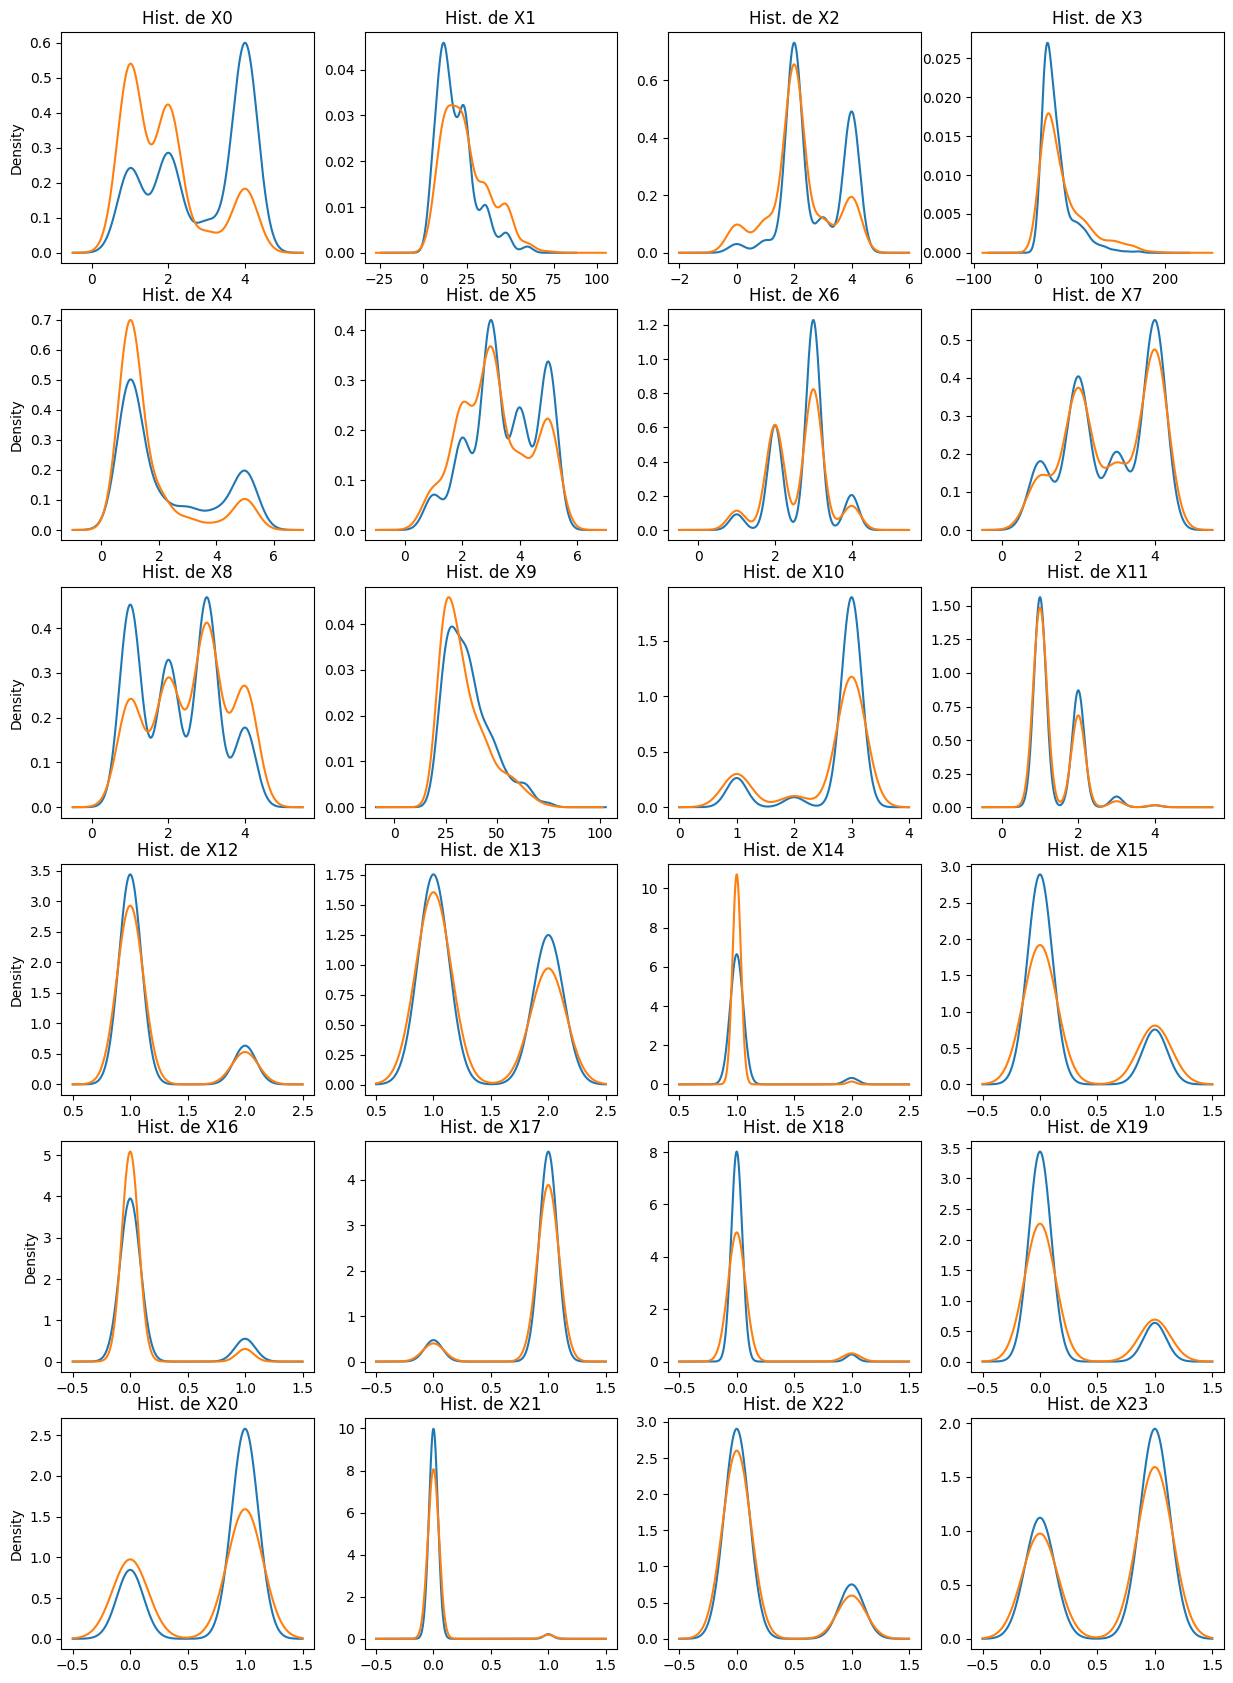

In [21]:
plt.figure(figsize=(15, 21))
n_cols_plot = 4
n_rows_plot = int(len(feature_names) / n_cols_plot)
for i,n in enumerate(feature_names):
    plt.subplot(n_rows_plot, n_cols_plot, i+1)
    aux = 'Density' if i%n_cols_plot == 0 else ''
    df.groupby('Class')[n].plot(kind='kde', title='Hist. de '+n)
    plt.ylabel(aux)

## Entrenamiento de un modelo y chequeo de su calidad usando 5-fold cross validation

La siguiente celda entrena un modelo y lo evalúa en varias particiones training-test diferentes de los datos. El resultado es un score medio junto a su desviación estándar. El tipo de modelo (Naïve Bayes / árbol de decisión / knn/ regresión logística / red neuronal) y parámetros empleados deberán ser seleccionados para que dicho resultado sea el mejor posible.

### Función que realiza el grid search de forma genérica

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) # division del entrenamiento

def train_n_check(grid_param, estimator):
    k_tests = RepeatedStratifiedKFold(n_splits=10, n_repeats=2) # Repite tests 
    grid_search = GridSearchCV(estimator(), grid_param, cv=k_tests, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    param_names =  list(grid_param.keys())
    print("Estimación de grid search:")
    for param_name in param_names: 
        print("- "+param_name +" = ", str(grid_search.best_params_[param_name]))
    return grid_search.best_params_

### Naïve Bayes
Se ha elegido var_smoothing porque es el único de los dos valores que tiene sentido ajustar para estos datos concretos

In [71]:
smooth_pow = 100
grid_param= {"var_smoothing": [i**(-i) for i in range(1,smooth_pow)]}
best_params = train_n_check(grid_param, GaussianNB)

clf = GaussianNB(var_smoothing= best_params['var_smoothing']) 
scores = cross_val_score(clf, X, y, cv=5) # 5-fold cross-validation


print('Precisión en cada una de las particiones: ', scores)
print('Estimación de la precisión por validación cruzada: {:.2f} +/- {:.2f}'.format(scores.mean(), scores.std()))

Estimación de grid search:
- var_smoothing =  0.00032
Precisión en cada una de las particiones:  [0.7   0.76  0.785 0.715 0.78 ]
Estimación de la precisión por validación cruzada: 0.75 +/- 0.03


### Arbol de Decisión
Se ha seleccionado max depth al ser el atributo más relevante de los árboles binarios (pues determina el número de reglas que hay como máximo antes de llegar a la conclusión sobre a que clase pertenece).


In [72]:
max_max_depth = 100
grid_param= {"max_depth": [i for i in range(1,max_max_depth)]}
best_params = train_n_check(grid_param, DecisionTreeClassifier)

clf = DecisionTreeClassifier(max_depth= best_params['max_depth'])

print('Precisión en cada una de las particiones: ', scores)
print('Estimación de la precisión por validación cruzada: {:.2f} +/- {:.2f}'.format(scores.mean(), scores.std()))

Estimación de grid search:
- max_depth =  3
Precisión en cada una de las particiones:  [0.7   0.76  0.785 0.715 0.78 ]
Estimación de la precisión por validación cruzada: 0.75 +/- 0.03


### Knn Neighbors
N neighbors es el parámetro más relevante de este algoritmo pues "suaviza" los bordes con las distintas clases que hay en el data set.

In [73]:
max_knn = 100
grid_param= {"n_neighbors": [i for i in range(1,max_knn)]}
best_params = train_n_check(grid_param, KNeighborsClassifier)

clf = KNeighborsClassifier(n_neighbors=best_params['n_neighbors']) 
scores = cross_val_score(clf, X, y, cv=5) # 5-fold cross-validation

print('Precisión en cada una de las particiones: ', scores)
print('Estimación de la precisión por validación cruzada: {:.2f} +/- {:.2f}'.format(scores.mean(), scores.std()))

Estimación de grid search:
- n_neighbors =  22
Precisión en cada una de las particiones:  [0.71  0.735 0.69  0.69  0.705]
Estimación de la precisión por validación cruzada: 0.71 +/- 0.02


### Regresión Logística
De este algoritmo se ha elegido tol para comprobar si con mayor o menor tolerancia a parar la ejecución, la regresión mejora o empeora.

In [74]:
tol_pow = 10
tol_list= [i**(-i) for i in range(1,tol_pow)]

grid_param= {"tol":tol_list, "solver":["lbfgs"], "max_iter": [1000], "penalty":["l2"]}
best_params = train_n_check(grid_param, LogisticRegression)

clf = LogisticRegression(penalty=best_params['penalty'],
                         tol=best_params['tol'],
                         max_iter=best_params['max_iter'],
                        solver=best_params["solver"]) 
scores = cross_val_score(clf, X_train, y_train, cv=5) # 5-fold cross-validation

print('Precisión en cada una de las particiones: ', scores)
print('Estimación de la precisión por validación cruzada: {:.2f} +/- {:.2f}'.format(scores.mean(), scores.std()))

Estimación de grid search:
- tol =  1.0
- solver =  lbfgs
- max_iter =  1000
- penalty =  l2
Precisión en cada una de las particiones:  [0.76 0.78 0.72 0.74 0.82]
Estimación de la precisión por validación cruzada: 0.76 +/- 0.03


### Red Neuronal
Se han elegido los parametros hidden layer sizes (para ir probando distintas combinaciones de neuronas y capas). Para ello se ha creado una función que crea una lista con el mismo numero de listas en su interior que capas máximas haya y dentro de cada lista habrá todas las distintas capas neuronas que como máximo han sido indicadas en cada capa. Tras esto se permuta aleatoriamente cada lista y se seleccionan los primeros elementos, de esta manera hay la misma cantidad de muestras por capa.

In [75]:
import random

def random_create_n_select_layers(min_neurons, min_layers, max_neurons, max_layers, num_combinations):
    '''
    Crea aleatoriamente un conjunto entre unas neuronas y capas dadas
        (se ha de proporcionar también el número de combinaciones totales).
    '''
    combinations = [[(j,)*i for j in range(min_neurons, max_neurons+1)] for i in range(min_layers, max_layers+1)]
    
    each_layer = int(num_combinations/max_layers)

    final =list()

    for i in range(max_layers):
            prov_list = combinations[i][: max_neurons]
            random.shuffle(prov_list)
            final+=(prov_list[:each_layer])
        
    return final
            
        

hidden_layer_sizes = random_create_n_select_layers(1,1,100,4, 10)

grid_param= {"max_iter": [9000], "hidden_layer_sizes":hidden_layer_sizes,
             "alpha":[0.0], "solver":["lbfgs"]}

best_params = train_n_check(grid_param, MLPClassifier)

clf = MLPClassifier(hidden_layer_sizes=best_params['hidden_layer_sizes'],
                    max_iter=best_params['max_iter'],
                    alpha=best_params['alpha'],
                    solver=best_params["solver"]) 

scores = cross_val_score(clf, X, y, cv=5) # 5-fold cross-validation

print('Precisión en cada una de las particiones: ', scores)
print('Estimación de la precisión por validación cruzada: {:.2f} +/- {:.2f}'.format(scores.mean(), scores.std()))


Estimación de grid search:
- max_iter =  9000
- hidden_layer_sizes =  (11,)
- alpha =  0.0
- solver =  lbfgs
Precisión en cada una de las particiones:  [0.76  0.76  0.745 0.76  0.755]
Estimación de la precisión por validación cruzada: 0.76 +/- 0.01


Parece que los más óptimo son 3 capas con 67 neuronas cada una.

## Responde aquí a las siguientes preguntas:

* Haz una gráfica que muestre la dependencia de la precisión de un clasificador de vecinos próximos con el número de vecinos. Si es más conveniente, utiliza gráficas en escala logarítmica para alguno de los ejes (`semilogx`, `semilogy`, `loglog`).
  

In [76]:
def make_graph_n_table(x_val, graph_x_val, headers, reps):
    data_table = []
    

    score_means = list()
    for i in x_val:
        scores = list()    
        for j in range(reps):
            if headers[0]== "max_depth":
                clf = DecisionTreeClassifier(max_depth = i) 
            elif headers[0] == "hidden_layer_sizes":
                clf = MLPClassifier(hidden_layer_sizes=i, max_iter=10000,alpha=0.0)
            else:
                clf = KNeighborsClassifier(n_neighbors=i) 
            clf.fit(X_train, y_train) # No me deja ejecutar score sin hacer
                                      # fit aunque no se entrene al modelo
                                      # imagino que cargará en memoria X_train e y_train
            scores.append(clf.score( X_test, y_test))
        m = mean(scores)
        score_means.append(m)
        data_table.append([i, m])
    
    print(pd.DataFrame({headers[0]:graph_x_val, headers[1]:score_means}).to_string(index=False))
    print()  
    
    plt.figure(figsize=(15, 20))
    
    plt.plot(graph_x_val, score_means)
    
    plt.loglog(graph_x_val, score_means)
    plt.xlabel("Numero de " + headers[0])
    plt.ylabel("Media de rendimiento")
    plt.title("Comparación según "+ headers[0])
    plt.show()
    
    scores_cpy = score_means.copy()
    
    scores_cpy.sort(reverse=True)
    
    print()
    print("Con "+headers[0]+" =", str(x_val[score_means.index(scores_cpy[0])]) + " , se tiene una puntuación de " + str(scores_cpy[0]))
    
    
    

 n_neighbors  Puntuacion media
           5             0.692
          10             0.720
          15             0.716
          20             0.714
          25             0.718
          30             0.706
          35             0.712
          40             0.702
          45             0.702
          50             0.700



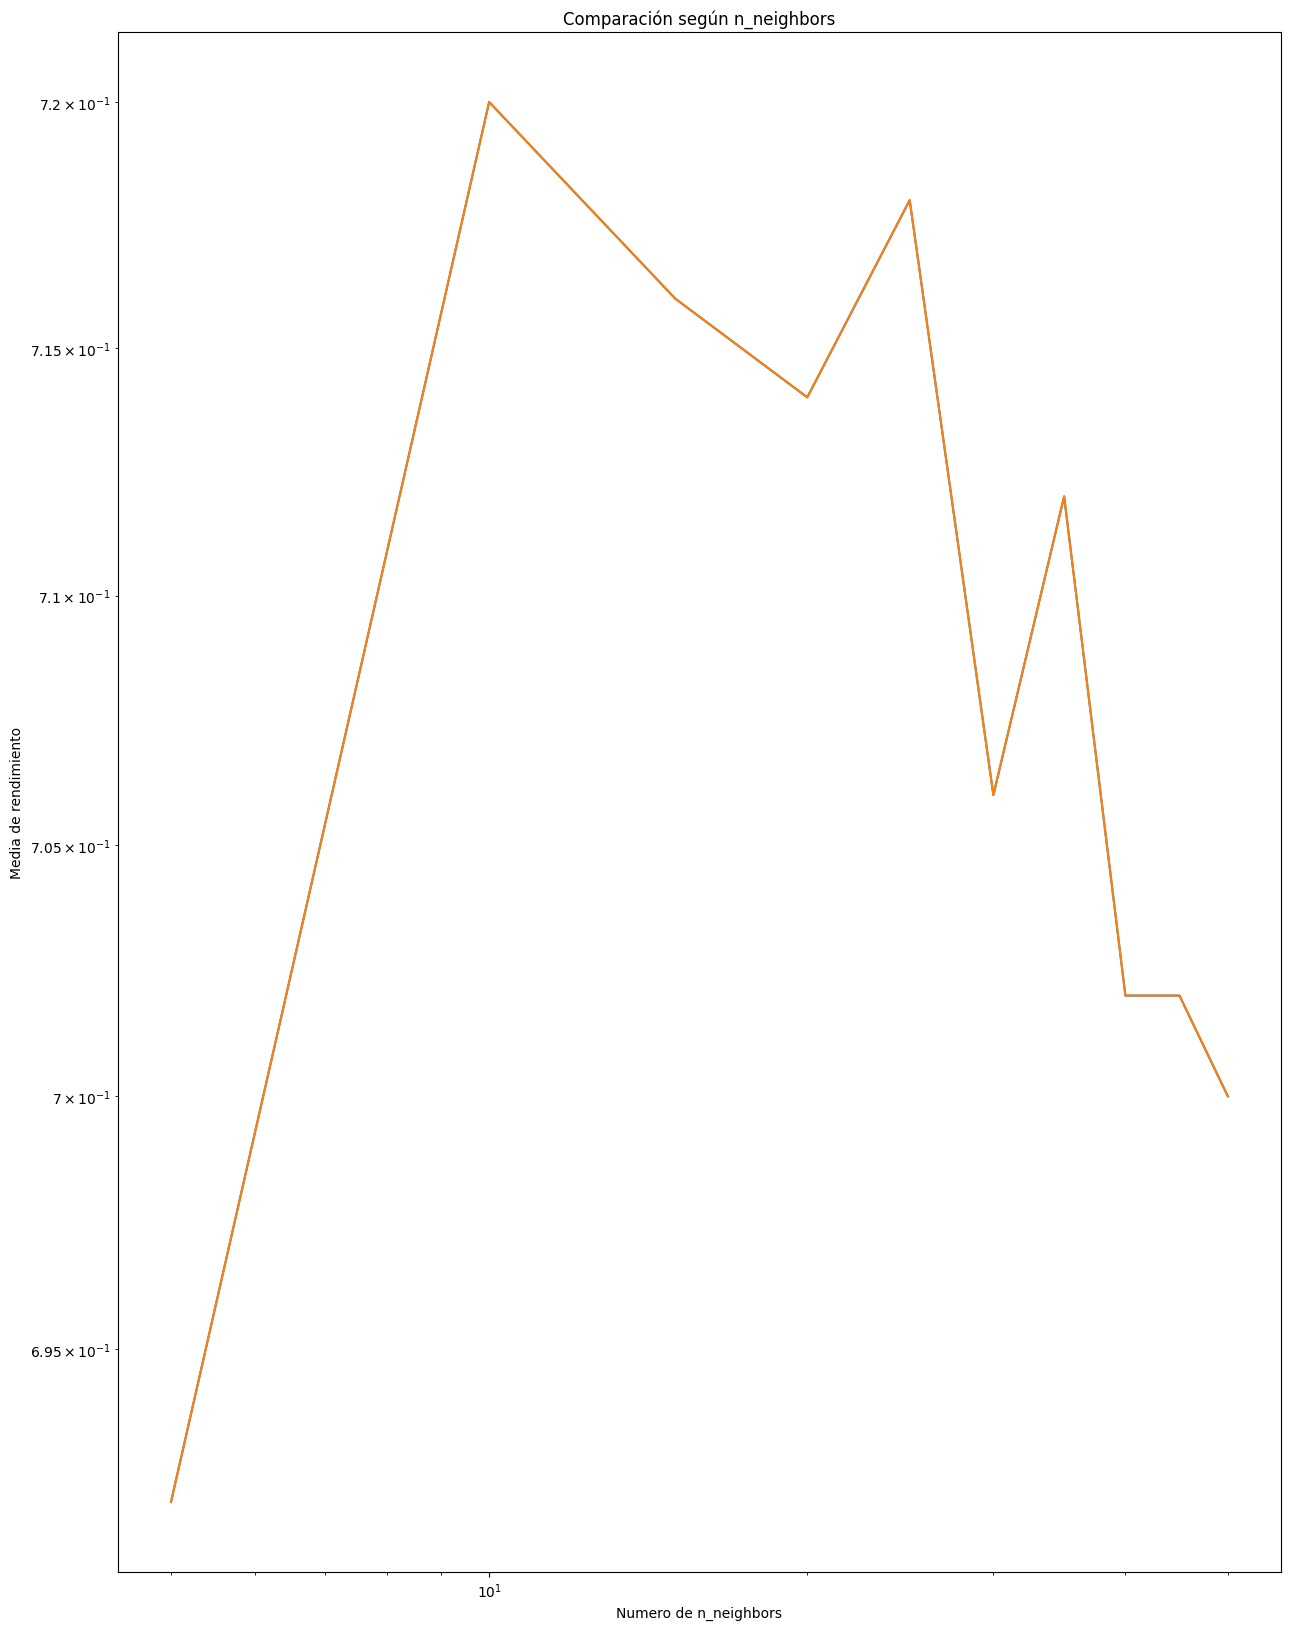


Con n_neighbors = 10 , se tiene una puntuación de 0.72


In [77]:



number_knn = 10
reps = 40
headers= ["n_neighbors", "Puntuacion media"]
x_val = [i*5  for i in range(1, number_knn+1)]

make_graph_n_table(x_val, x_val, headers, reps)

* Utilizando los conceptos de sub- y sobreajuste:
    * Comenta los resultados cuando el número de vecinos es pequeño.
    * Comenta los resultados cuando el número de vecinos es grande.
    * Explica el significado del valor de la precisión cuando el número de vecinos toma el valor mayor posible.
      

Cuando es pequeño (en este caso 5) la puntuación media es bastante peor que con mas vecinos, está subajustado pues no consigue encontrar realmente una diferencia clara entre las distintas áreas de los datos. Al aumentar en 5 los vecinos, la media de rendimiento aumenta notablemente, esto se debe a que el numero de vecinos actua como un "smoothing parameter" y al aumentarlo, en teoría, da mejores resultados, no obstante, hay valores de k que son más grandes y son subóptimos. Esto se debe a que con demasiados vecinos hay un sobreajuste y el algoritmo empieza a ajustarse a datos más especificos, perdiendo capacidad de predictibilidad.

* ¿Cuál es la mejor precisión que se alcanza con k-nn y para qué k (valor de `n_neighbours`)?
  

Para hallar el valor de k más óptimo, se ha utilizado GridSearchCV, que trata de estimar el mejor valor para un parametro (ejecución unas celdas más arriba). En este caso la estimación es de k = 27, lo cual coincide con la gráfica y la tabla.

* ¿Cuál es la mejor precisión que se alcanza con un árbol de decisión y con qué profundidad máxima (valor de `max_depth`)? Para ello, haz una gráfica que muestre la dependencia de la precisión con la profundidad máxima del árbol. Comenta los resultados.
  

 max_depth  Puntuacion media
         5           0.72160
        10           0.69950
        15           0.69210
        20           0.69255
        25           0.69015
        30           0.68995
        35           0.69115
        40           0.69095
        45           0.69045
        50           0.69135



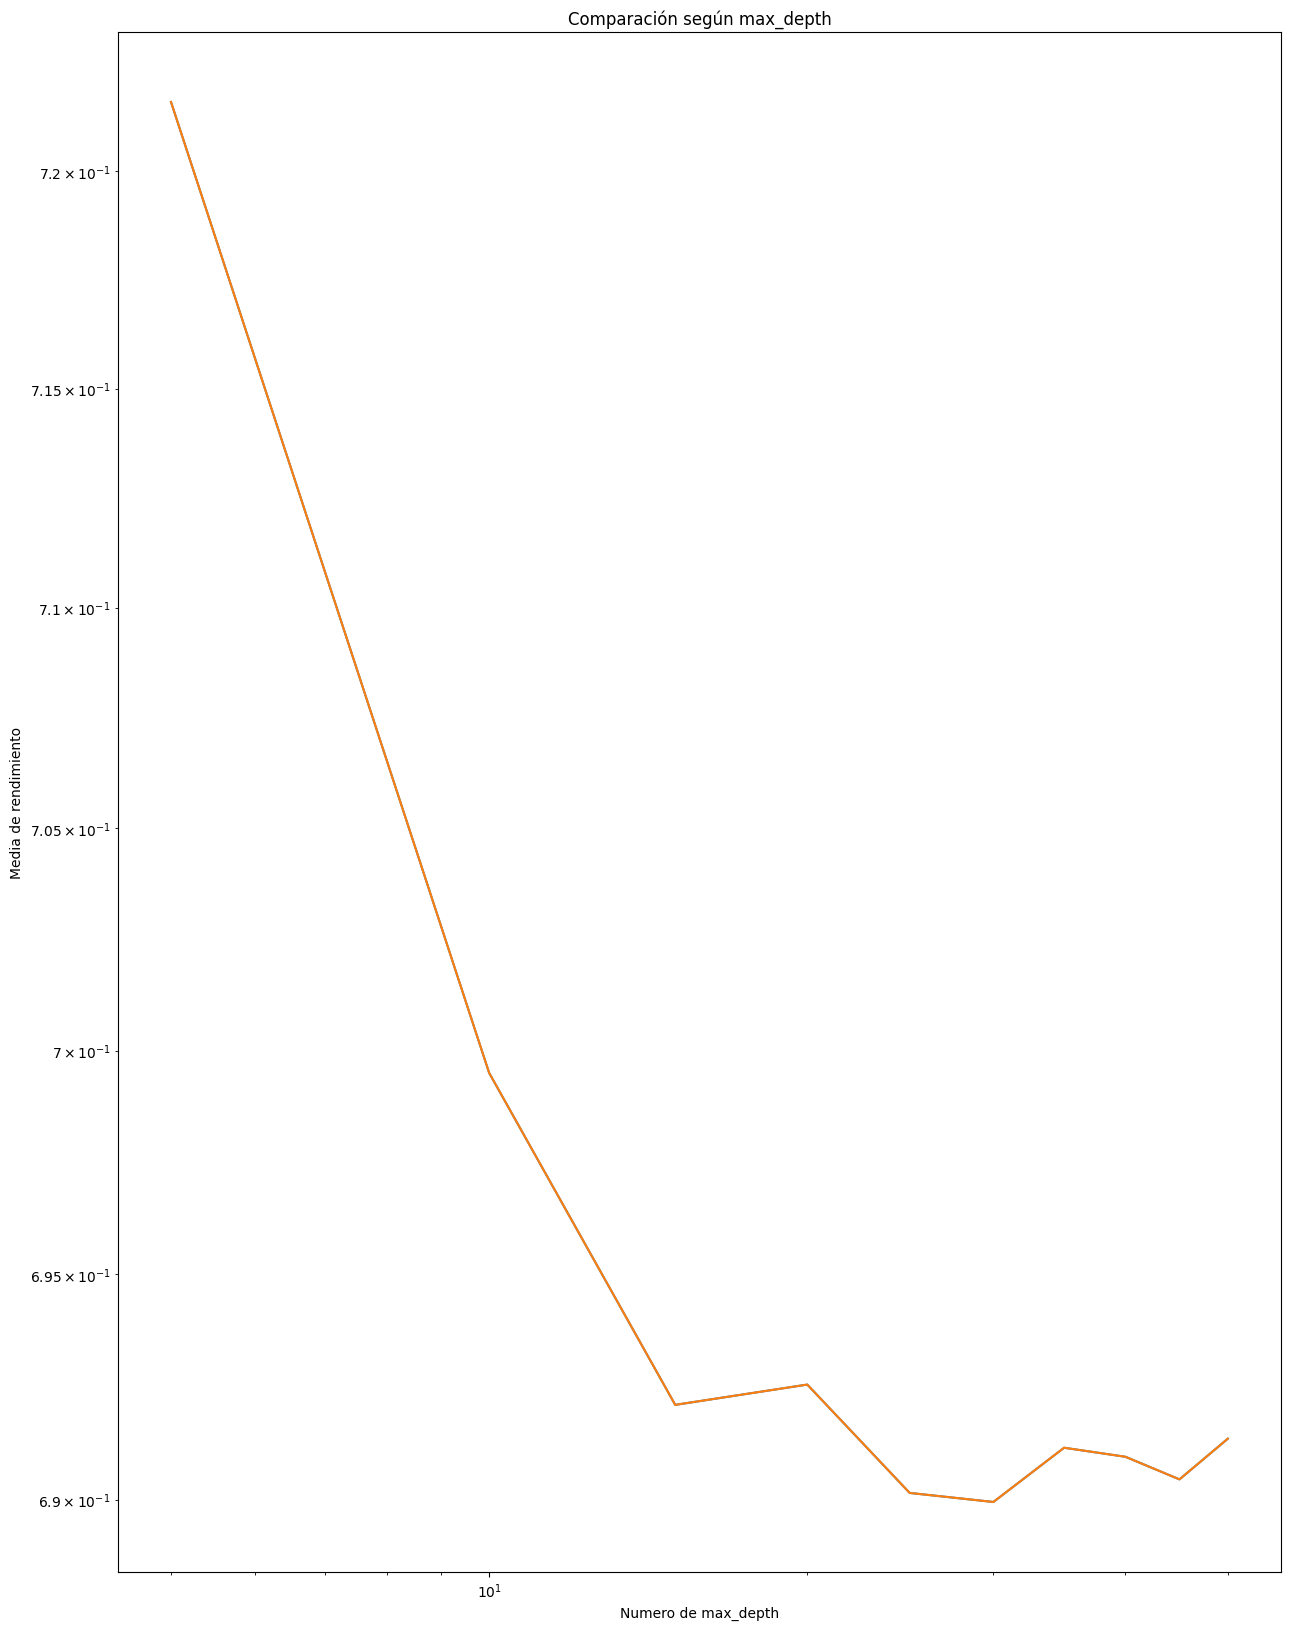


Con max_depth = 5 , se tiene una puntuación de 0.7216


In [78]:
number_depth = 10

x_val = [i*5  for i in range(1, number_depth+1)]



headers= ["max_depth", "Puntuacion media"]
reps = 40

make_graph_n_table(x_val, x_val, headers, reps)



Tal y como muestra la gráfica, una profundidad superior a 5 parece poco eficiente y tras el uso de GridSearchCV, la estimación de la profundidad es 3, lo que coincide con la gráfica y la tabla.

* ¿Cuál es la mejor precisión que se alcanza con una red neuronal con una sola capa oculta y con qué configuración (valor de `hidden_layer_sizes`)? Para ello, haz una gráfica que muestre la dependencia de la precisión con el número de nodos en la capa oculta. Comenta los resultados.

 hidden_layer_sizes  Puntuacion media
                 10           0.74725
                 20           0.75585
                 30           0.75635
                 40           0.75615
                 50           0.75580
                 60           0.75920
                 70           0.76105
                 80           0.76175
                 90           0.75975
                100           0.75950



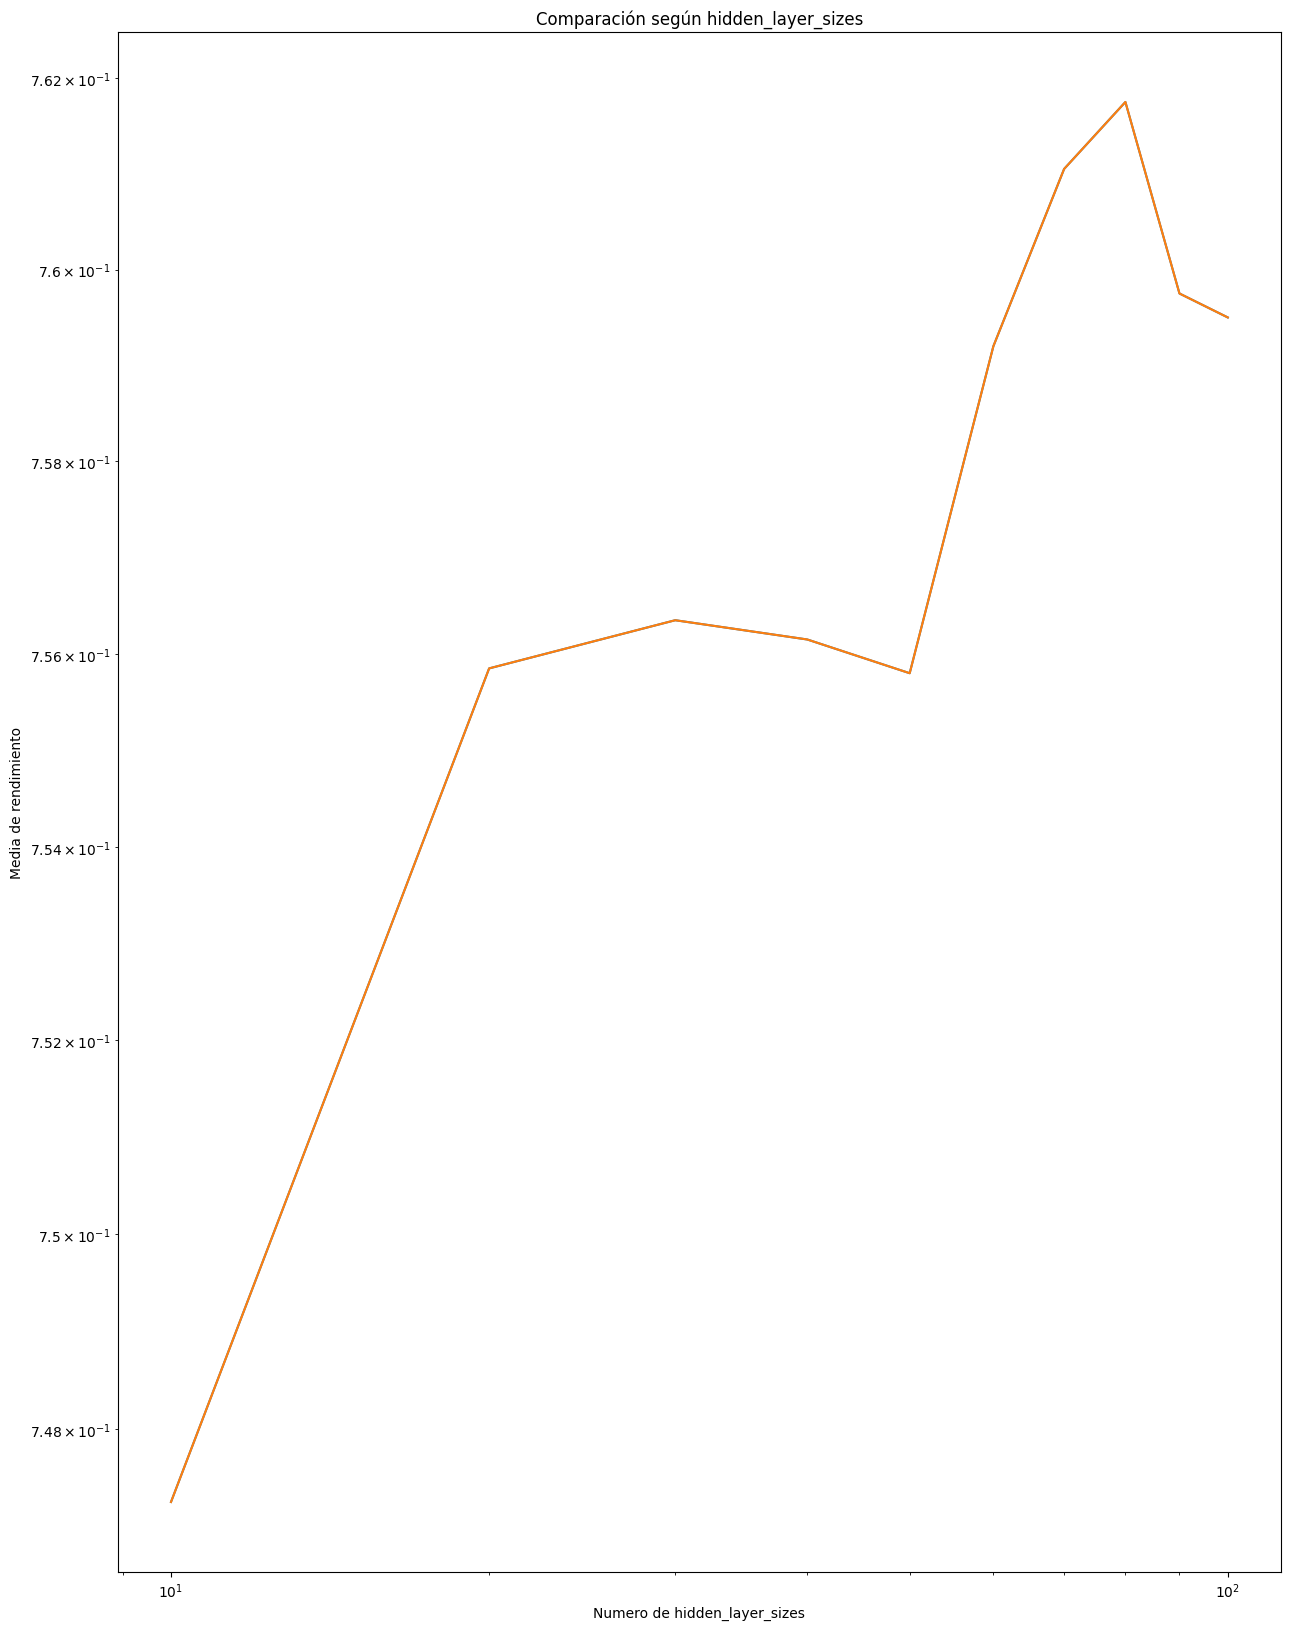


Con hidden_layer_sizes = (80,) , se tiene una puntuación de 0.76175


In [79]:

number_neurons = 10
reps = 40

x_val = [(i*10,) for i in range(1, number_neurons+1)]
x_val_graph = [i*10 for i in range(1, number_neurons+1)]

headers= ["hidden_layer_sizes", "Puntuacion media"]

make_graph_n_table(x_val, x_val_graph, headers, reps)


En base a la ejecución anterior, el número optimo de neuronas ronda en torno a 30 neuronas. 

* ¿Cuál es la mejor precisión que se alcanza con una red neuronal con varias capas ocultas y con qué configuración? Para ello, haz una gráfica que muestre la dependencia de la precisión con el número de capas ocultas, suponiendo constante el número de nodos en cada capa oculta. Comenta los resultados.
* Resume los resultados y conclusiones del estudio realizado.

**Además de gráficas, puede ser conveniente presentar los resultados en forma de tablas.**

 hidden_layer_sizes  Puntuacion media
                  1           0.76065
                  2           0.75325
                  3           0.74570
                  4           0.74085
                  5           0.74525
                  6           0.74025
                  7           0.74135
                  8           0.74160
                  9           0.74015
                 10           0.74015



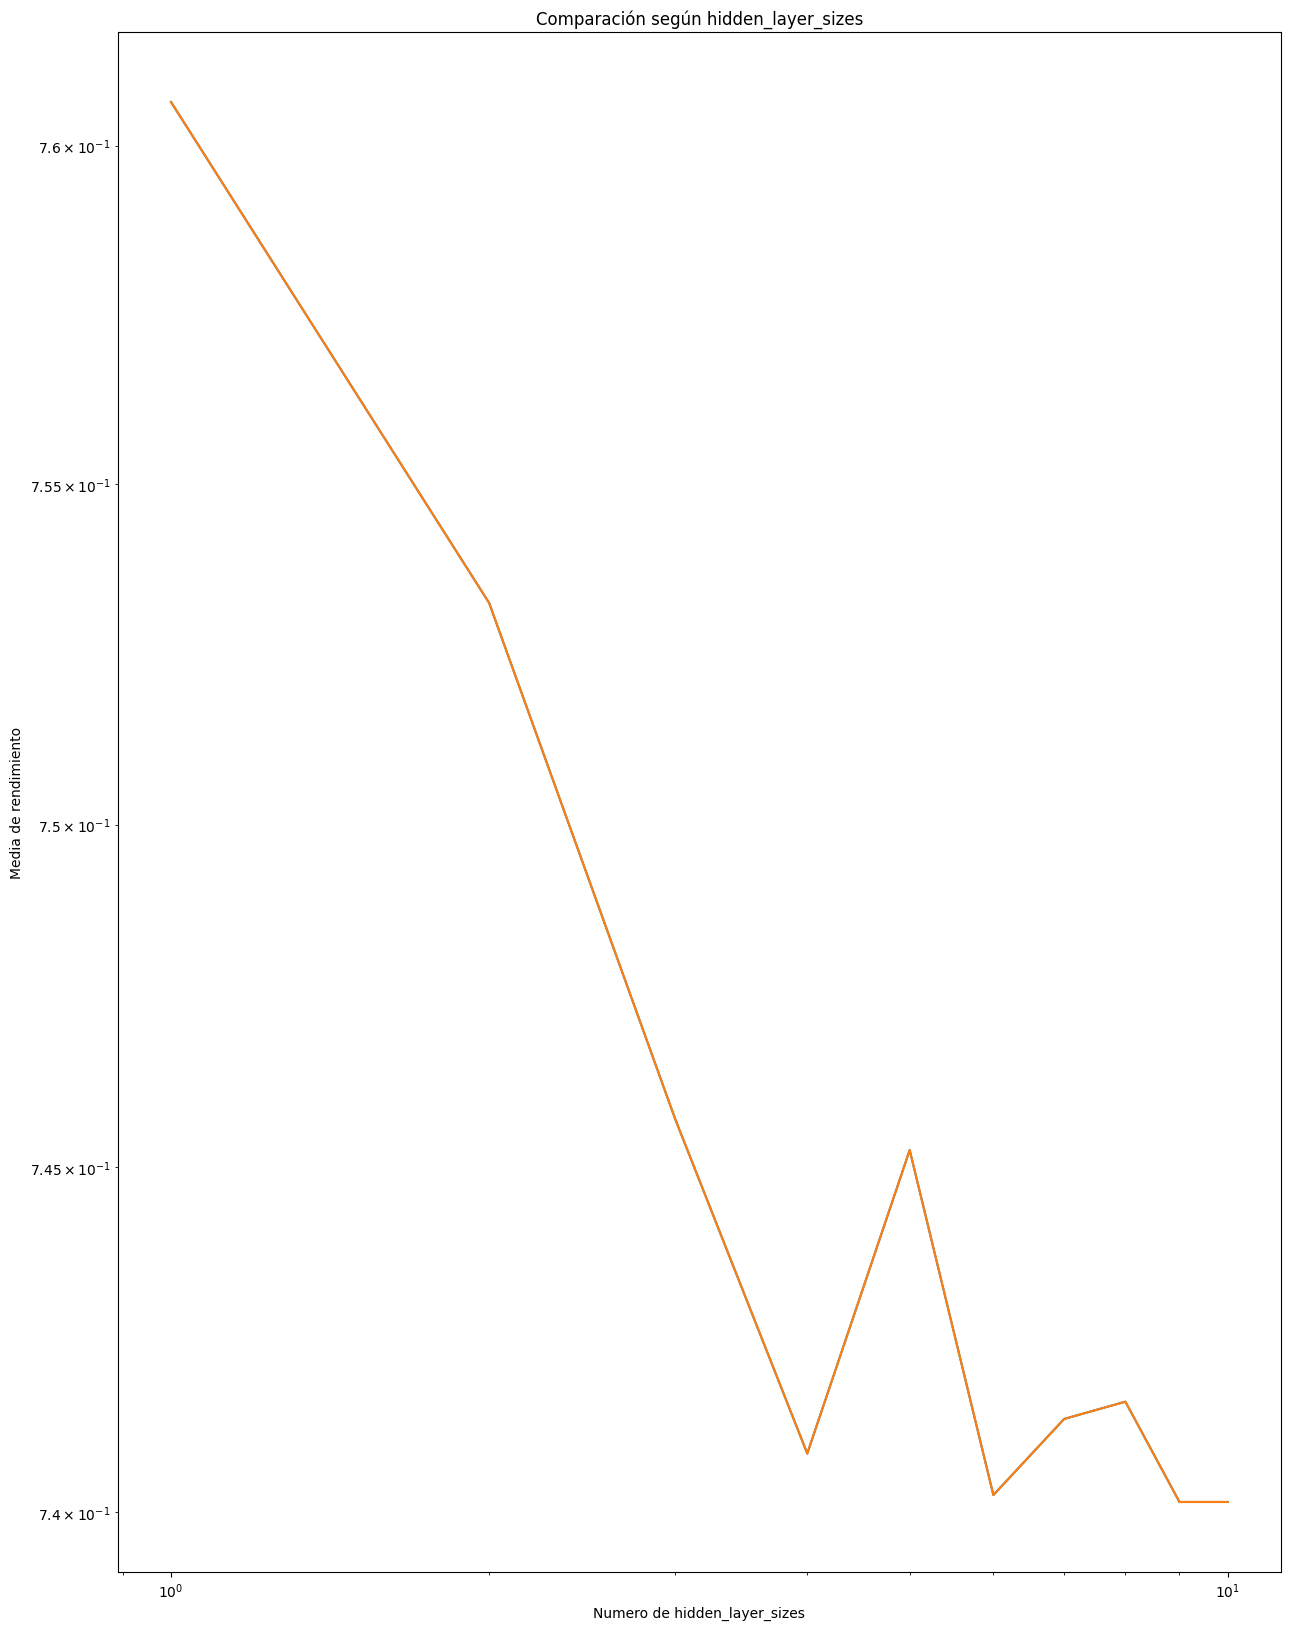


Con hidden_layer_sizes = (70,) , se tiene una puntuación de 0.76065


In [80]:
number_layers = 10
reps = 40

x_val = [(70,)*i for i in range(1, number_layers+1)]
x_val_graph = [i for i in range(1, number_layers+1)]

headers= ["hidden_layer_sizes", "Puntuacion media"]

make_graph_n_table(x_val, x_val_graph, headers, reps)


Como parece reflejar la gráfica, para este conjunto de datos lo más óptimo serían 3 capas ocultas con 30 neuronas cada una (para este conjunto de datos en concreto).

## Procesamiento

En ocasiones, en lugar de utilizar modelos más complejos, es más útil invertir más tiempo en el procesamiento de los datos para conseguir mejores resultados.

En este apartado vas a investigar mecanismos para preparar los datos y obtener (en principio) mejores resultados: construcción y selección de atributos, preprocesamiento (detección de outliers, missing values, centrado y escalado).

Razona por qué decides probar o ignorar alguno de estos métodos, y cómo cambian los resultados al aplicarlos (puedes crear tantas celdas como consideres oportunas).
Usa tablas, gráficas y código, según sea necesario, para ilustrar tus observaciones.

In [81]:
df = pd.read_csv('./data/german_credit_data_numeric.csv', sep=';')
class_label = 'Class'
feature_names = list(df.columns)
feature_names.remove(class_label)
X = df[feature_names].values
y = df[class_label].values
# seleccion de atributos

# Se obtienen los distintos conjuntos de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


### Construcción y selección de atributos

Los datos son información acerca de los clientes de una sucursal bancaria

1. Analisis conceptual de los atributos:

| Atributo | Definición | Elegido |
|----------|----------|----------|
| default  | Class   | Si   |
| account_check_status    | Tener una cuenta corriente  | Si   |
| duration_in_month   | Haber estado muchos meses   | Si   |
| credit_history   | Haber tenido deudas   | Si   |
| purpose   |  Pedir creditos para distintos bienes | Si   |
| savings   | Ahorros   | Si   |
| credit_amount | La cantidad de crédito | Si |
| present_emp_since   | Tiempo que lleva presente   | No   |
| installment_as_income_perc   | Pagan algo a plazos  | Si   |
| personal_status_sex   | Estado civil y sexo    | Si   |
| other_debtors   |  No se realmente a que se refiere con otros deudores   |  No  |
| present_res_since   | Tampoco se que es    | No   |
| property   | Las propiedades  | Si   |
| age   |  La edad   | Si   |
| other_installment_plans   | Podía llegar a ser relevante, pero hay muchos missing values | No   |
| housing   | Si tiene casa    | Si   |
| credits_this_bank   | Las deudas con el banco  |  Si  |
| job   |  Los trabajos  | Si   |
| people_under_maintenance   |  Personas a las que mantiene  | Si   |
| telephone   |  El telefono |  No  |
| foreign_worker   |  Trabajador extranjero  |  Si   |
   
* Cuando se habla de estabilidad respecto a deudas, es porque se asume que el banco no te da ningún prestamo si no tiene la certeza de que vayas a poder pagarlo.
* Se asume que el extranjero va a tener menos establidad porque acaba de llegar al país.
  
# pandas histogramas para ver correl
# entrenar clasificadores para ver con que atributos dan mejores scores

### Preprocesamiento

#### Outlier detection

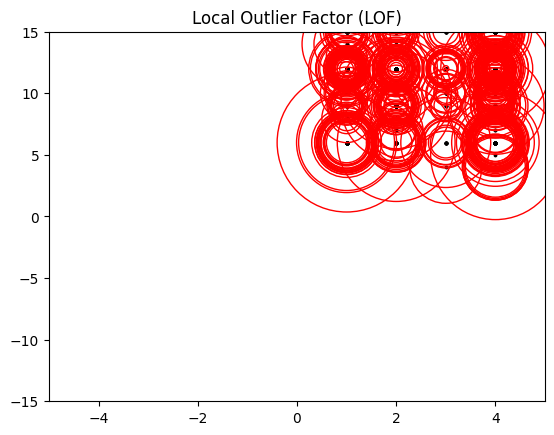

In [82]:
clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_

plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
# radio del circulo
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
scatter = plt.scatter(
    X[:, 0],
    X[:, 1],
    s=10000* radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-15, 15))

plt.title("Local Outlier Factor (LOF)")
plt.show()

A través de la función LocalOutlierFactor, se pueden obtener los Outliers scores, es decir la desviación de la densidad local. En el caso del dataset dado, como se puede apreciar hay muchos outliers.

#### Missing Values

In [83]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train_vals = train_test_split(imp.transform(X_train))
X_test_valss = train_test_split(imp.transform(X_test))

normal_scores= list()
normal_scores_train= list()
no_missing_scores= list()
no_missing_scores_train= list()


for i in range(10):
    
    clf = MLPClassifier(hidden_layer_sizes=(30,30,30,), max_iter=3000,alpha=0.0) # 3000 iteraciones para evitar el ConvergenceWarning
    clf.fit(X_train, y_train) # entrenamiento
    # comprobar los 2 
    scores = clf.score(clf, X_test, y_test) # test
    
    normal_scores.append(mean(scores))
    
    clf2 = MLPClassifier(hidden_layer_sizes=(30,30,30,), max_iter=3000,alpha=0.0) # 3000 iteraciones para evitar el ConvergenceWarning
        
    clf2.fit(X_train_vals, y_train_vals) # entrenamiento
    scores = clf2.score(clf, X_test, y_test) # test
    
    no_missing_scores.append(mean(scores))
    
print("Con los datos normales ", mean(normal_scores),
      "\nHabiendo sustituido los datos faltantes", mean(no_missing_scores))


ValueError: Expected 2D array, got scalar array instead:
array=MLPClassifier(alpha=0.0, hidden_layer_sizes=(30, 30, 30), max_iter=3000).
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Parece que no hay mucha mejoría, esto se puede deber a que o bien no faltan datos, o bien son muy pocos los faltantes.

#### Estandarización 

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
# preprocesamiento - estandarización
# se estandariza el data set
# mirar pagina
scaler = preprocessing.StandardScaler()

X_train_selected = scaler.fit_transform(X_train)

X_test_selected = scaler.transform(X_test)


scaler_scores= list()
no_scaler_scores= list()

for i in range(10):
    
    clf = MLPClassifier(hidden_layer_sizes=(30,30,30,), max_iter=3000,alpha=0.0) # 3000 iteraciones para evitar el ConvergenceWarning
    clf.fit(X_train_selected, y_train)
        
    y_pred = clf.predict(X_test_selected)
    scores = accuracy_score(y_test, y_pred)
    scaler_scores.append(scores)

    
    clf2 = MLPClassifier(hidden_layer_sizes=(30,30,30,), max_iter=3000,alpha=0.0) # 3000 iteraciones para evitar el ConvergenceWarning
    clf2.fit(X_train_selected, y_train)
        
    y_pred = clf2.predict(X_test_selected)
    scores = accuracy_score(y_test, y_pred)
    no_scaler_scores.append(scores)
    
print("Con StandardScaler ", mean(scaler_scores), "\nSin StandardScaler", mean(no_scaler_scores))


In [ ]:
# preprocesamiento - estandarización
# se estandariza el data set

scaler = preprocessing.MinMaxScaler()

X_train_selected = scaler.fit_transform(X_train)

X_test_selected = scaler.transform(X_test)

scaler_scores= list()
no_scaler_scores= list()

for i in range(10):
    
    clf = MLPClassifier(hidden_layer_sizes=(30,30,30,), max_iter=3000,alpha=0.0) # 3000 iteraciones para evitar el ConvergenceWarning
    clf.fit(X_train_selected, y_train)
        
    y_pred = clf.predict(X_test_selected)
    scores = accuracy_score(y_test, y_pred)
    scaler_scores.append(scores)

    
    clf2 = MLPClassifier(hidden_layer_sizes=(30,30,30,), max_iter=3000,alpha=0.0) # 3000 iteraciones para evitar el ConvergenceWarning
    clf2.fit(X_train_selected, y_train) # entrenamiento
        
    y_pred = clf2.predict(X_test_selected)
    scores = accuracy_score(y_test, y_pred)
    no_scaler_scores.append(scores)
    
print("Con MinMaxScaler ", mean(scaler_scores), "\nSin MinMaxScaler", mean(no_scaler_scores))

Parece que no hay mucha diferencia, lo cual significa o bien que el centrado y escalado no tiene mucho peso con respecto a la predicción de las redes neuronales, o bien que los datos de 'german_credit_data_numeric.csv' ya están estandarizados.

## Hiperparámetros


¿Cómo se determina el valor de los hiperparámetros?

Para determinar el valor de los hiperparámetros de un modelo realizaremos una búsqueda en una rejilla. De entre los valores considerados seleccionaremos los que maximicen la estimación por validación cruzada (K = 10) de la tasa de acierto.

Adapta el código que encontrarás en 
[https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py)
a este problema. 

En los tutoriales
[https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html](
    https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
[https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
hay información sobre cada uno de los hiper-parámetros. 
Puedes elegir el conjunto de hiperparametros en el que se realiza la optimización. 
Antes de elegir la rejilla de hiperparámetros, asegúrate de que entiendes su para asegurarte que tiene sentido la búsqueda.

In [ ]:
def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()

def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a precision threshold
    of 0.98, rank the remaining by recall and keep all models with one standard
    deviation of the best by recall. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores
    precision_threshold = 0.98

    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_precision_cv_results = cv_results_[
        cv_results_["mean_test_precision"] > precision_threshold
    ]

    print(f"Models with a precision higher than {precision_threshold}:")
    print_dataframe(high_precision_cv_results)

    high_precision_cv_results = high_precision_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_precision",
            "std_test_precision",
            "rank_test_recall",
            "rank_test_precision",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_recall_std = high_precision_cv_results["mean_test_recall"].std()
    best_recall = high_precision_cv_results["mean_test_recall"].max()
    best_recall_threshold = best_recall - best_recall_std

    high_recall_cv_results = high_precision_cv_results[
        high_precision_cv_results["mean_test_recall"] > best_recall_threshold
    ]
    print(
        "Out of the previously selected high precision models, we keep all the\n"
        "the models within one standard deviation of the highest recall model:"
    )
    print_dataframe(high_recall_cv_results)

    # From the best candidates, select the fastest model to predict
    fastest_top_recall_high_precision_index = high_recall_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and recall.\n"
        "Its scoring time is:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index


# ----------------------------------------------------------


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

max_knn = 100
grid_param= {"n_neighbors": [i for i in range(1,max_knn)]}

scores = ["precision", "recall"]

grid_search = GridSearchCV(
    KNeighborsClassifier(), grid_param, scoring=scores, refit=refit_strategy
)


max_max_depth = 100
grid_param= {"max_depth": [i for i in range(1,max_max_depth)]}
grid_search.fit(X_train, y_train)


grid_search = GridSearchCV(
    DecisionTreeClassifier(), grid_param, scoring=scores, refit=refit_strategy
)
grid_search.fit(X_train, y_train)


## ¿Cómo se estima el error de generalización?

Estimaremos el error de generalización de cada clasificador usando *Nested Cross Validation*. 


Adapta el código que encontrarás en https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html para resolver este problema con una red neuronal. 


In [ ]:

# Number of random trials
NUM_TRIALS = 1

# Load the dataset
X_iris = X
y_iris = y

# Set up possible values of parameters to optimize over
# random search de layersizes
p_grid = {"hidden_layer_sizes": [(100,),(30,30,30,), (15,30,20,), (15,20,30,), (30,20,15,), (100,30,)], 
          "learning_rate":["constant", "invscaling", "adaptive"]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = MLPClassifier(max_iter=3000,alpha=0.0)

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):
    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("score", fontsize="14")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Non-Nested and Nested Cross Validation on Iris Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1, 0.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

## ¿Cuál es el mejor clasificador?

* De acuerdo con los resultados de los anteriores apartados, indica cuál es el mejor clasificador encontrado.
* ¿Cuáles son los valores de los hiperparámetros utilizados para configurar y entrenar tal  clasificador?
* ¿cuáles son los valores de los parámetros del clasificador entrenado?
* Proporciona una estimación del error de generalización por validación cruzada, así como de la incertidumbre de dicha estimación.


## Conclusiones.
Resume los resultados y conclusiones del estudio que has realizado.


[POR HACER]
